In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#IMPORTS
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [3]:
loc = 'nw2'
turbine = 'c02'

# GET THE DATA
package_folder = os.path.dirname(os.path.dirname(os.getcwd()))
data_folder = os.path.join(package_folder, 'data')
models_folder = os.path.join(package_folder, 'models')
ss2_selected = pd.read_csv(os.path.join(data_folder, 'processed','nw2', turbine+'_ss2_selected_data_large.csv'))
ss2_selected['timestamp'] = pd.to_datetime(ss2_selected['timestamp'])
ss2_selected.set_index('timestamp', inplace=True)

SS1_dbscan = pd.read_parquet(os.path.join(data_folder, 'interim',loc,'tracked_modes', 'dbscan_based', loc+turbine+'_SS1_mode.parquet'))
SS2_dbscan = pd.read_parquet(os.path.join(data_folder, 'interim',loc,'tracked_modes', 'dbscan_based', loc+turbine+'_SS2_mode.parquet'))
FA1_dbscan = pd.read_parquet(os.path.join(data_folder, 'interim',loc,'tracked_modes', 'dbscan_based', loc+turbine+'_FA1_mode.parquet'))
FA2_dbscan = pd.read_parquet(os.path.join(data_folder, 'interim',loc,'tracked_modes', 'dbscan_based', loc+turbine+'_FA2_mode.parquet'))

rfe_selected_data = pd.read_parquet(os.path.join(data_folder, 'interim', loc, 'rfe_selected_data', loc+turbine+'_rfe_selected_data.parquet'))

In [5]:
rfe_selected_data.columns

Index(['mvbc_WandelaarBuoy_10%_highest_waves',
       'mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Sea_water_temperature',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_pressure', 'mean_NW2_C02_rpm',
       'mean_NW2_C02_yaw', 'mean_NW2_C02_pitch', 'mean_NW2_C02_power',
       'mean_NW2_C02_winddirection'],
      dtype='object')

In [24]:
import pandas as pd
from sklearn.metrics import mean_squared_error

def corr_sparcity_plot_values_smart_tracked(prediction_df_, target_, corr_:pd.Series, smart_tracked_modes_full):
    prediction_df = prediction_df_.copy()
    target = target_.copy()
    smart_tracked_modes_ = smart_tracked_modes_full.copy()
    corr = corr_.copy().loc[smart_tracked_modes_.index]

    corr_df = pd.DataFrame({'frequency':smart_tracked_modes_['frequency'], 'Corr': corr})

    # Pre-compute the order of dropping based on 'knowledge_uncertainty'
    drop_order = smart_tracked_modes_['knowledge_uncertainty'].argsort()

    # Pre-calculate the corr for the entire dataset
    initial_corr = corr_df.corr().iloc[0,1]
    initial_mse = mean_squared_error(prediction_df['prediction'].loc[smart_tracked_modes_.index], smart_tracked_modes_['frequency'], squared=False)
    # Pre-allocate memory for sparcity_values
    corr_sparcity_values = [initial_corr] * len(prediction_df)
    mse_sparcity_values = [initial_mse] * len(prediction_df)
    prediction_df.reset_index(inplace=True, drop=True)
    target.reset_index(inplace=True, drop=True)
    corr.reset_index(inplace=True, drop=True)
    smart_tracked_modes_.reset_index(inplace=True, drop=True)
    for i in range(len(smart_tracked_modes_) - 1):
        # Drop the next row in the pre-calculated order
        corr.drop(drop_order.iloc[-(i+1)], inplace=True)
        smart_tracked_modes_.drop(drop_order.iloc[-(i+1)], inplace=True)
        prediction_df.drop(drop_order.iloc[-(i+1)], inplace=True)
        target.drop(drop_order.iloc[-(i+1)], inplace=True)

        # Update the MSE in sparcity_values
        mse_i = mean_squared_error(prediction_df['prediction'].loc[smart_tracked_modes_.index], smart_tracked_modes_['frequency'], squared=True)
        mse_sparcity_values[i+1] = mse_i

        corr_df = pd.DataFrame({'frequency':smart_tracked_modes_['frequency'], 'Corr': corr})
        corr_i = corr_df.corr().iloc[0,1]
        corr_sparcity_values[i + 1] = corr_i
    return corr_sparcity_values, mse_sparcity_values

In [25]:
smart_tracked_modes_spacity_modes = {}
mse_sparcity_values_modes = {}

# SS1

In [26]:
mode = 'SS1'

X = rfe_selected_data.copy()
y = SS1_dbscan.copy()
y = y.sort_values(by=['size'])
y = y[~y.index.duplicated(keep='first')][['mean_frequency']]

#preprocess
from src.data.preprocessing import sin_cos_angle_inputs
X = sin_cos_angle_inputs(X)
Xy = y.copy()
for col in X.columns:
    Xy[col] = X[col]
X = Xy[X.columns]
y = y[y.columns]

# Split in training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from catboost import CatBoostRegressor

regr_model = CatBoostRegressor(
    iterations=2000,
    depth=3,
    learning_rate=0.05,
    l2_leaf_reg=3,
    random_seed=0,
    posterior_sampling=True,
    loss_function='RMSEWithUncertainty',
    verbose=False)

#regr_model = CatBoostRegressor(posterior_sampling=True, loss_function='RMSEWithUncertainty', verbose=False)
regr_model.fit(X_train, y_train)

# Full model predictions
predictions = regr_model.predict(X)
predictions_df = pd.DataFrame(predictions, columns=['prediction', 'spread'], index=X.index)
predicted_value = predictions[:,0]
predicted_total_uncertainty = predictions[:,1]

# Virtual ensemble predictions
virtual_ensemble_preds = regr_model.virtual_ensembles_predict(X, prediction_type='TotalUncertainty', virtual_ensembles_count=500, ntree_end=1000) #, virtual_ensembles_count=100, ntree_end=200)
virtual_ensemble_preds_df = pd.DataFrame(virtual_ensemble_preds, columns=['prediction', 'knowledge uncertainty', 'data uncertainty'], index=X.index)

virtual_ensemble_preds_mean = virtual_ensemble_preds[:,0] # mean values predicted by a virtual ensemble
knowledge_uncertainty = virtual_ensemble_preds[:,1] # knowledge uncertainty predicted by a virtual ensemble
data_uncertainty = virtual_ensemble_preds[:,2] # average estimated data uncertainty


# Predictions
from src.smart_tracking.smart_tracking import smart_tracking

uncertainty_ = pd.Series(knowledge_uncertainty, index=X.index).copy()
uncertainty_moving_avg = pd.Series(uncertainty_, index=X.index).rolling(6*6, center=True).mean()
uncertainty_lim = uncertainty_moving_avg.loc[X_train.index].quantile(0.99)

prediction_lim = (y['mean_frequency'] - predictions_df['prediction']).loc[X_train.index].quantile(0.99)
prediction_lim = (y['mean_frequency'] - predictions_df['prediction']).loc[X_train.index].std()*3


smart_tracked_modes = smart_tracking(y['mean_frequency'], predictions_df['prediction'], uncertainty_moving_avg, uncertainty_lim, prediction_lim)

predictions_df['virtual_ensemble_mean'] = virtual_ensemble_preds_mean
predictions_df['knowledge_uncertainty'] = knowledge_uncertainty
predictions_df['data_uncertainty'] = data_uncertainty
predictions_df['residual'] = y['mean_frequency'] - predictions_df['prediction']


smart_tracked_modes_all = smart_tracking(y['mean_frequency'], predictions_df['prediction'], uncertainty_moving_avg, uncertainty_moving_avg.max(), prediction_lim)
smart_tracked_modes_all['knowledge_uncertainty'] = predictions_df['knowledge_uncertainty']

correlation_param = pd.Series(X.filter(regex='Tide').values[:,0], index=X.index)
smart_tracked_modes_spacity_modes[mode], mse_sparcity_values_modes[mode] = corr_sparcity_plot_values_smart_tracked(predictions_df, y, correlation_param, smart_tracked_modes_all)

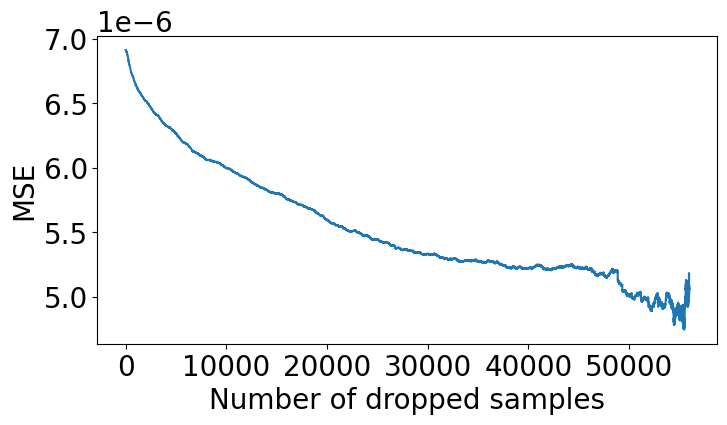

In [27]:
limit = 56000
plt.figure(figsize=(8,4))
plt.plot(mse_sparcity_values_modes['SS1'][1:limit])
plt.xlabel('Number of dropped samples')
plt.ylabel('MSE')
plt.show()
plt.close()

# FA1

In [28]:
mode ='FA1'

X = rfe_selected_data.copy()
y = FA1_dbscan.copy()
y = y.sort_values(by=['size'])
y = y[~y.index.duplicated(keep='first')][['mean_frequency']]

#preprocess
from src.data.preprocessing import sin_cos_angle_inputs
X = sin_cos_angle_inputs(X)
Xy = y.copy()
for col in X.columns:
    Xy[col] = X[col]
X = Xy[X.columns]
y = y[y.columns]

# Split in training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from catboost import CatBoostRegressor

regr_model = CatBoostRegressor(
    iterations=2000,
    depth=3,
    learning_rate=0.05,
    l2_leaf_reg=3,
    random_seed=0,
    posterior_sampling=True,
    loss_function='RMSEWithUncertainty',
    verbose=False)

#regr_model = CatBoostRegressor(posterior_sampling=True, loss_function='RMSEWithUncertainty', verbose=False)
regr_model.fit(X_train, y_train)

# Full model predictions
predictions = regr_model.predict(X)
predictions_df = pd.DataFrame(predictions, columns=['prediction', 'spread'], index=X.index)
predicted_value = predictions[:,0]
predicted_total_uncertainty = predictions[:,1]

# Virtual ensemble predictions
virtual_ensemble_preds = regr_model.virtual_ensembles_predict(X, prediction_type='TotalUncertainty', virtual_ensembles_count=500, ntree_end=1000) #, virtual_ensembles_count=100, ntree_end=200)
virtual_ensemble_preds_df = pd.DataFrame(virtual_ensemble_preds, columns=['prediction', 'knowledge uncertainty', 'data uncertainty'], index=X.index)

virtual_ensemble_preds_mean = virtual_ensemble_preds[:,0] # mean values predicted by a virtual ensemble
knowledge_uncertainty = virtual_ensemble_preds[:,1] # knowledge uncertainty predicted by a virtual ensemble
data_uncertainty = virtual_ensemble_preds[:,2] # average estimated data uncertainty


# Predictions
from src.smart_tracking.smart_tracking import smart_tracking

uncertainty_ = pd.Series(knowledge_uncertainty, index=X.index).copy()
uncertainty_moving_avg = pd.Series(uncertainty_, index=X.index).rolling(6*6, center=True).mean()
uncertainty_lim = uncertainty_moving_avg.loc[X_train.index].quantile(0.99)

prediction_lim = (y['mean_frequency'] - predictions_df['prediction']).loc[X_train.index].quantile(0.99)
prediction_lim = (y['mean_frequency'] - predictions_df['prediction']).loc[X_train.index].std()*3


smart_tracked_modes = smart_tracking(y['mean_frequency'], predictions_df['prediction'], uncertainty_moving_avg, uncertainty_lim, prediction_lim)

predictions_df['virtual_ensemble_mean'] = virtual_ensemble_preds_mean
predictions_df['knowledge_uncertainty'] = knowledge_uncertainty
predictions_df['data_uncertainty'] = data_uncertainty
predictions_df['residual'] = y['mean_frequency'] - predictions_df['prediction']


smart_tracked_modes_all = smart_tracking(y['mean_frequency'], predictions_df['prediction'], uncertainty_moving_avg, uncertainty_moving_avg.max(), prediction_lim)
smart_tracked_modes_all['knowledge_uncertainty'] = predictions_df['knowledge_uncertainty']

correlation_param = pd.Series(X.filter(regex='Tide').values[:,0], index=X.index)
smart_tracked_modes_spacity_modes[mode], mse_sparcity_values_modes[mode] = corr_sparcity_plot_values_smart_tracked(predictions_df, y, correlation_param, smart_tracked_modes_all)

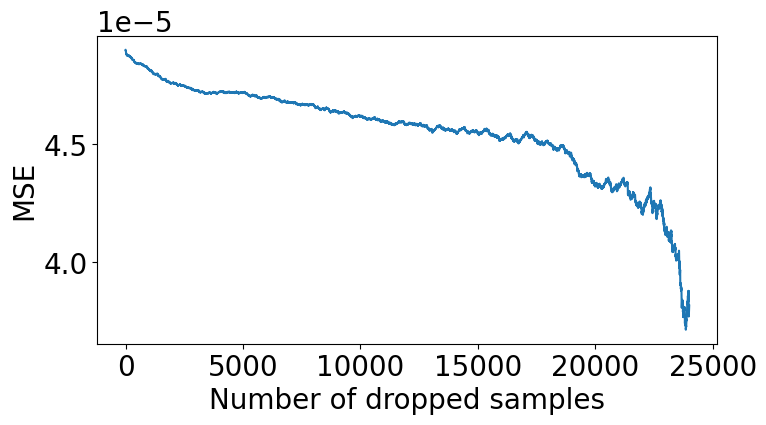

In [29]:
limit = 24000
plt.figure(figsize=(8,4))
plt.plot(mse_sparcity_values_modes['FA1'][1:limit])
plt.xlabel('Number of dropped samples')
plt.ylabel('MSE')
plt.show()
plt.close()

In [30]:
mode ='SS2'

X = rfe_selected_data.copy()
y_ = ss2_selected.copy()
y_ = y_.sort_values(by=['size'])
y_ = y_[~y_.index.duplicated(keep='first')][['mean_frequency']]

y = SS2_dbscan.copy()
y = y.sort_values(by=['size'])
y = y[~y.index.duplicated(keep='first')][['mean_frequency']]
#preprocess
from src.data.preprocessing import sin_cos_angle_inputs
X = sin_cos_angle_inputs(X)
Xy = y_.copy()
for col in X.columns:
    Xy[col] = X[col]
X_train = Xy[X.columns]
y_train = y_[y_.columns]

from catboost import CatBoostRegressor

regr_model = CatBoostRegressor(
    iterations=2000,
    depth=3,
    learning_rate=0.05,
    l2_leaf_reg=3,
    random_seed=0,
    posterior_sampling=True,
    loss_function='RMSEWithUncertainty',
    verbose=False)

#regr_model = CatBoostRegressor(posterior_sampling=True, loss_function='RMSEWithUncertainty', verbose=False)
regr_model.fit(X_train, y_train)

# Full model predictions
predictions = regr_model.predict(X)
predictions_df = pd.DataFrame(predictions, columns=['prediction', 'spread'], index=X.index)
predicted_value = predictions[:,0]
predicted_total_uncertainty = predictions[:,1]

# Virtual ensemble predictions
virtual_ensemble_preds = regr_model.virtual_ensembles_predict(X, prediction_type='TotalUncertainty', virtual_ensembles_count=500, ntree_end=1000) #, virtual_ensembles_count=100, ntree_end=200)
virtual_ensemble_preds_df = pd.DataFrame(virtual_ensemble_preds, columns=['prediction', 'knowledge uncertainty', 'data uncertainty'], index=X.index)

virtual_ensemble_preds_mean = virtual_ensemble_preds[:,0] # mean values predicted by a virtual ensemble
knowledge_uncertainty = virtual_ensemble_preds[:,1] # knowledge uncertainty predicted by a virtual ensemble
data_uncertainty = virtual_ensemble_preds[:,2] # average estimated data uncertainty


# Predictions
from src.smart_tracking.smart_tracking import smart_tracking

uncertainty_ = pd.Series(knowledge_uncertainty, index=X.index).copy()
uncertainty_moving_avg = pd.Series(uncertainty_, index=X.index).rolling(6*6, center=True).mean()
uncertainty_lim = uncertainty_moving_avg.loc[X_train.index].quantile(0.9)

prediction_lim = (y['mean_frequency'] - predictions_df['prediction']).loc[X_train.index].quantile(0.99)
prediction_lim = (y['mean_frequency'] - predictions_df['prediction']).loc[X_train.index].std()*3


smart_tracked_modes = smart_tracking(y['mean_frequency'], predictions_df['prediction'], uncertainty_, uncertainty_lim, prediction_lim)

predictions_df['virtual_ensemble_mean'] = virtual_ensemble_preds_mean
predictions_df['knowledge_uncertainty'] = knowledge_uncertainty
predictions_df['data_uncertainty'] = data_uncertainty
predictions_df['residual'] = y['mean_frequency'] - predictions_df['prediction']


smart_tracked_modes_all = smart_tracking(y['mean_frequency'], predictions_df['prediction'], uncertainty_moving_avg, uncertainty_moving_avg.max(), prediction_lim)
smart_tracked_modes_all['knowledge_uncertainty'] = predictions_df['knowledge_uncertainty']

correlation_param = pd.Series(X.filter(regex='Tide').values[:,0], index=X.index)
smart_tracked_modes_spacity_modes[mode], mse_sparcity_values_modes[mode] = corr_sparcity_plot_values_smart_tracked(predictions_df, y, correlation_param, smart_tracked_modes_all)

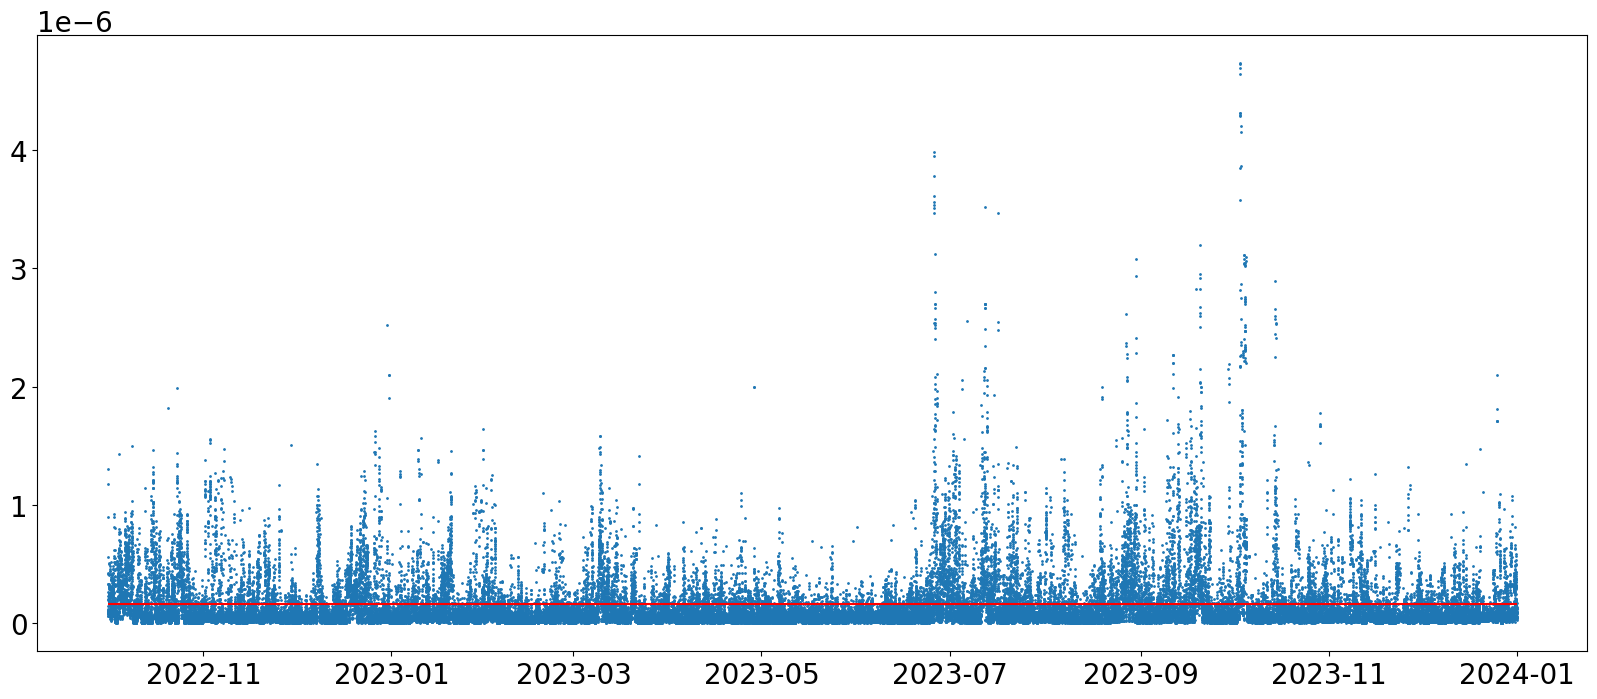

In [31]:
plt.figure(figsize=(20,8))
plt.scatter(predictions_df.index, predictions_df['knowledge_uncertainty'],s=1)
plt.hlines(uncertainty_lim, predictions_df.index[0], predictions_df.index[-1], color='r')

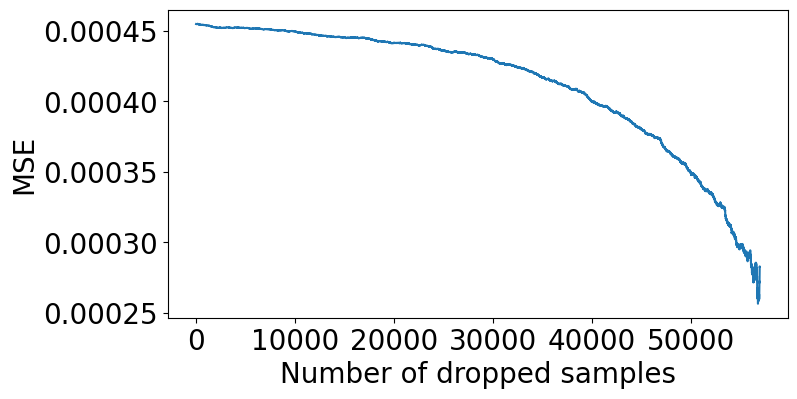

In [32]:
limit = 57000
plt.figure(figsize=(8,4))
plt.plot(mse_sparcity_values_modes['SS2'][1:limit])
plt.xlabel('Number of dropped samples')
plt.ylabel('MSE')
plt.show()
plt.close()

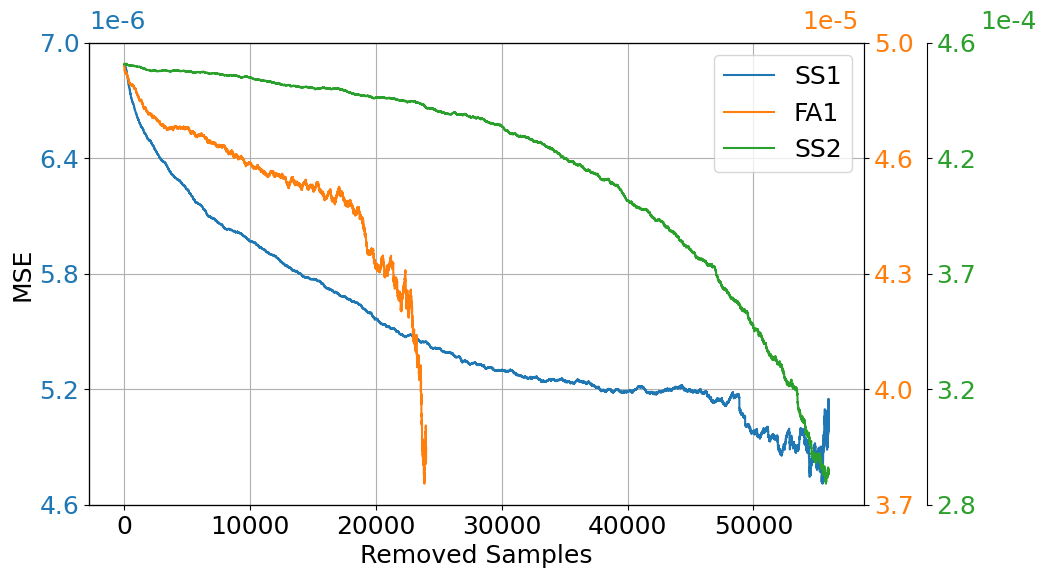

In [33]:
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator
import numpy as np

plt.rcParams.update({'font.size': 18})

def format_y_ticks(value, _):
    return f'{value:.1f}'

# Assuming mse_sparcity_values_modes is your dictionary
modes = list(mse_sparcity_values_modes.keys())
n_modes = len(modes)
limits = [56000, 24000, 56000]  # example limits for the x-axis
colors = ['tab:blue', 'tab:orange', 'tab:green']  # colors for each mode

fig, ax = plt.subplots(figsize=(10, 6))
axes = [ax]  # List to store all the axes for setting legend and colors
numSteps = 5

# Custom scaling factor for each mode (adjust these as needed)
scaling_factors = [1e6, 1e5, 1e4]
scaling_factors_locations = [(0, 1.03), (0.92, 1.03), (1.15, 1.03)]

# Plot on the original axis for the first mode
data = mse_sparcity_values_modes[modes[0]][1:limits[0]]
scaled_data = np.array(data) * scaling_factors[0]
axes[0].plot(scaled_data, label=modes[0], color=colors[0])
axes[0].tick_params(axis='y', labelcolor=colors[0])
axes[0].set_ylabel('MSE')
axes[0].set_xlabel('Removed Samples')
axes[0].grid(True)
axes[0].yaxis.set_major_locator(LinearLocator(numSteps))
exponent_text = f"1e-{int(np.log10(scaling_factors[0]))}"
axes[0].annotate(exponent_text, xy=scaling_factors_locations[0], xycoords='axes fraction', color=colors[0])
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(format_y_ticks))

# Now we ensure that all twin axes are created from the primary axis, 'ax'
for i, mode in enumerate(modes[1:], start=1):
    axes.append(ax.twinx())
    new_axis = axes[-1]

    # Scale the data for the current mode
    data = mse_sparcity_values_modes[mode][1:limits[i]]
    scaled_data = np.array(data) * scaling_factors[i]

    new_axis.plot(scaled_data, label=mode, color=colors[i])
    new_axis.tick_params(axis='y', labelcolor=colors[i])
    #new_axis.set_ylabel(mode, color=colors[i])
    new_axis.yaxis.set_major_locator(LinearLocator(numSteps))
    new_axis.spines['right'].set_position(('outward', 45 * (i-1)))

    # Add the exponent as text on top of the y-axis
    exponent_text = f"1e-{int(np.log10(scaling_factors[i]))}"
    new_axis.annotate(exponent_text, xy=scaling_factors_locations[i], xycoords='axes fraction', color=colors[i])
    axes[i].yaxis.set_major_formatter(plt.FuncFormatter(format_y_ticks))


# Set a general legend for all axes
fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.88))
plt.show()


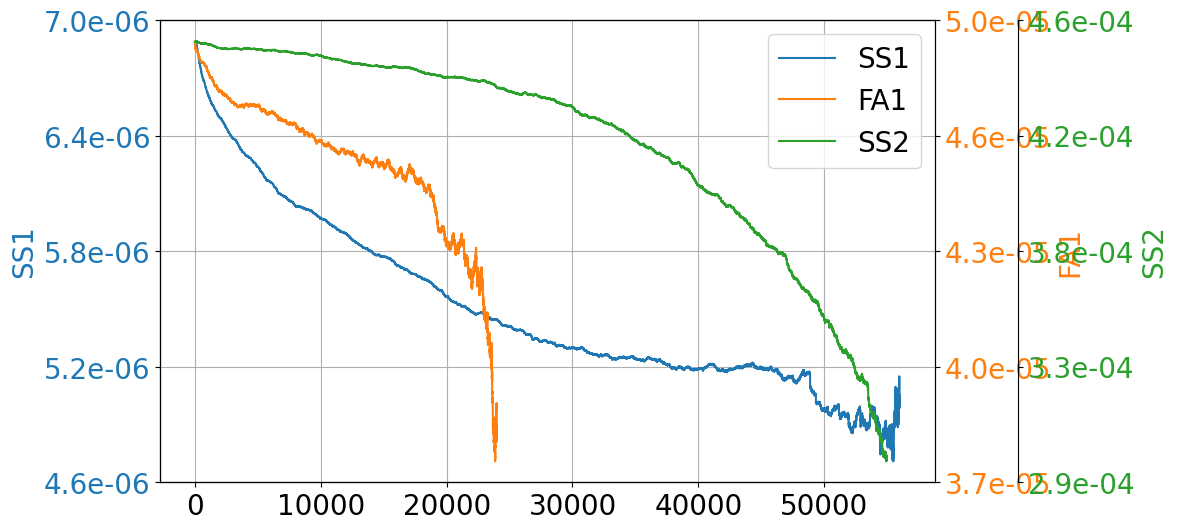

In [34]:
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator  # Import the LinearLocator for evenly spaced ticks
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter
plt.rcParams.update({'font.size': 20})
# Enforce 1 digit after the decimal point


# Assuming mse_sparcity_values_modes is your dictionary
modes = list(mse_sparcity_values_modes.keys())
n_modes = len(modes)
limits = [56000, 24000, 55000]  # example limits for the x-axis
colors = ['tab:blue', 'tab:orange', 'tab:green']  # colors for each mode

fig, ax = plt.subplots(figsize=(10, 6))
axes = [ax]  # List to store all the axes for setting legend and colors
numSteps = 5
# Plot on the original axis for the first mode
axes[0].plot(mse_sparcity_values_modes[modes[0]][1:limits[0]], label=modes[0], color=colors[0])
axes[0].tick_params(axis='y', labelcolor=colors[0])
axes[0].set_ylabel(modes[0], color=colors[0])  # Set the y-axis label
axes[0].grid(True)  # Enable grid for the primary y-axis
axes[0].yaxis.set_major_locator(LinearLocator(numSteps))  # Use LinearLocator to get evenly spaced ticks
# Now we ensure that all twin axes are created from the primary axis, 'ax'
for i, mode in enumerate(modes[1:], start=1):
    axes.append(ax.twinx())  # Always twin the primary axis
    new_axis = axes[-1]

    new_axis.plot(mse_sparcity_values_modes[mode][1:limits[i]], label=mode, color=colors[i])
    new_axis.tick_params(axis='y', labelcolor=colors[i])
    new_axis.set_ylabel(mode, color=colors[i])
    
    # Use LinearLocator to get evenly spaced ticks
    new_axis.yaxis.set_major_locator(LinearLocator(numSteps))

    # Offset each successive axis to the right
    new_axis.spines['right'].set_position(('outward', 60 * (i-1)))    
    
# Set a general legend for all axes
fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.88))


# Custom formatter for one digit after the decimal in scientific notation
def custom_formatter(x, pos):
    return f"{x:.1e}"

# Apply the custom formatter to your existing axes
for ax in axes:
    ax.yaxis.set_major_formatter(FuncFormatter(custom_formatter))

# Adjust the offset text for the last axis (SS2, which is green in your case)
# This axis is the last one created, so it's the last in the 'axes' list
last_axis = axes[-1]
offset_text = last_axis.yaxis.get_offset_text()
offset_text.set_position((1, 0))  # Move the exponent to the right
offset_text.set_horizontalalignment('right')

plt.show()


In [57]:
np.round(np.linspace(yticks[i][0], yticks[i][1], 10),1)

array([3. , 3.2, 3.3, 3.5, 3.7, 3.8, 4. , 4.2, 4.3, 4.5])

In [72]:
np.linspace(0, len(scaled_data), len(scaled_data))/len(scaled_data)

array([0.00000000e+00, 1.81824794e-05, 3.63649587e-05, ...,
       9.99963635e-01, 9.99981818e-01, 1.00000000e+00])

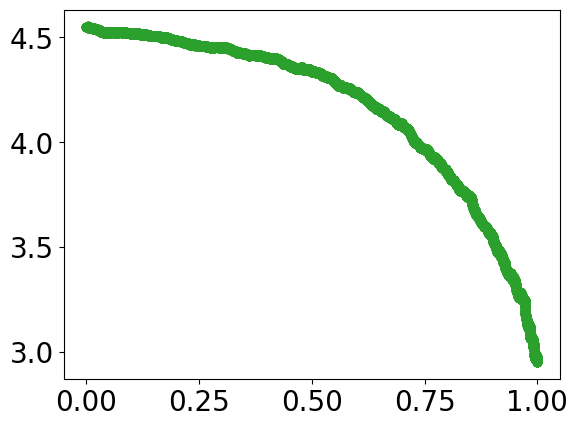

In [73]:
plt.scatter(np.linspace(0, len(scaled_data), len(scaled_data))/len(scaled_data), scaled_data, label=mode, color=colors[i])

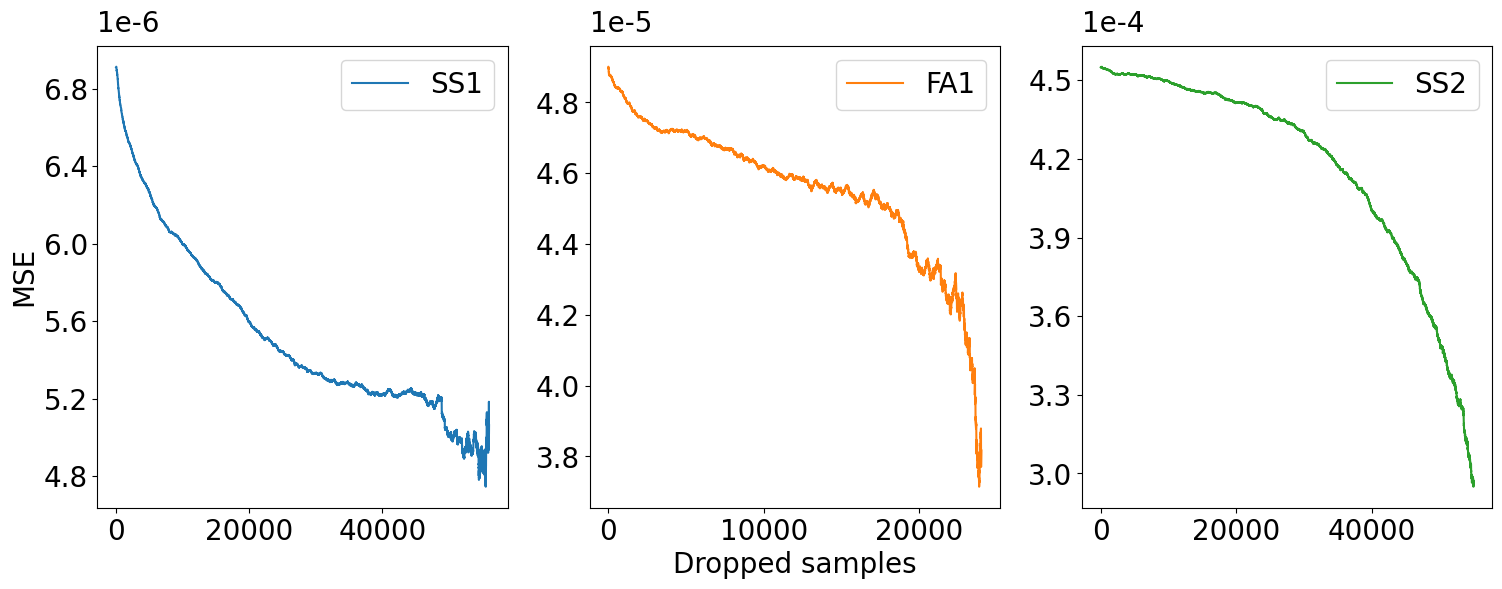

In [74]:
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator  # Import the LinearLocator for evenly spaced ticks
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter
plt.rcParams.update({'font.size': 20})
# Enforce 1 digit after the decimal point


# Assuming mse_sparcity_values_modes is your dictionary
modes = list(mse_sparcity_values_modes.keys())
n_modes = len(modes)
limits = [56000, 24000, 55000]  # example limits for the x-axis
colors = ['tab:blue', 'tab:orange', 'tab:green']  # colors for each mode
scaling_factors = [1e6, 1e5, 1e4]

yticks = [(4.8,6.8), (3.8, 4.8), (3, 4.5)]

fig, axs  = plt.subplots(1, n_modes, figsize=(18, 6))

# Now we ensure that all twin axes are created from the primary axis, 'ax'
for i, mode in enumerate(modes):
    scaled_data = np.array(mse_sparcity_values_modes[mode][1:limits[i]]) * scaling_factors[i]
    axs[i].plot(scaled_data, label=mode, color=colors[i])
    axs[i].legend(loc="upper right")
    exponent_text = f"1e-{int(np.log10(scaling_factors[i]))}"
    axs[i].annotate(exponent_text, xy=(0, 1.03), xycoords='axes fraction')

    axs[i].set_yticks(np.round(np.linspace(yticks[i][0], yticks[i][1], 6),1))

# def custom_formatter(x, pos):
#     return f"{x:.1e}"

# # Apply the custom formatter to your existing axes
# for ax in axs:
#     ax.yaxis.set_major_formatter(FuncFormatter(custom_formatter))

axs[1].set_xlabel('Dropped samples')
axs[0].set_ylabel('MSE')


plt.show()


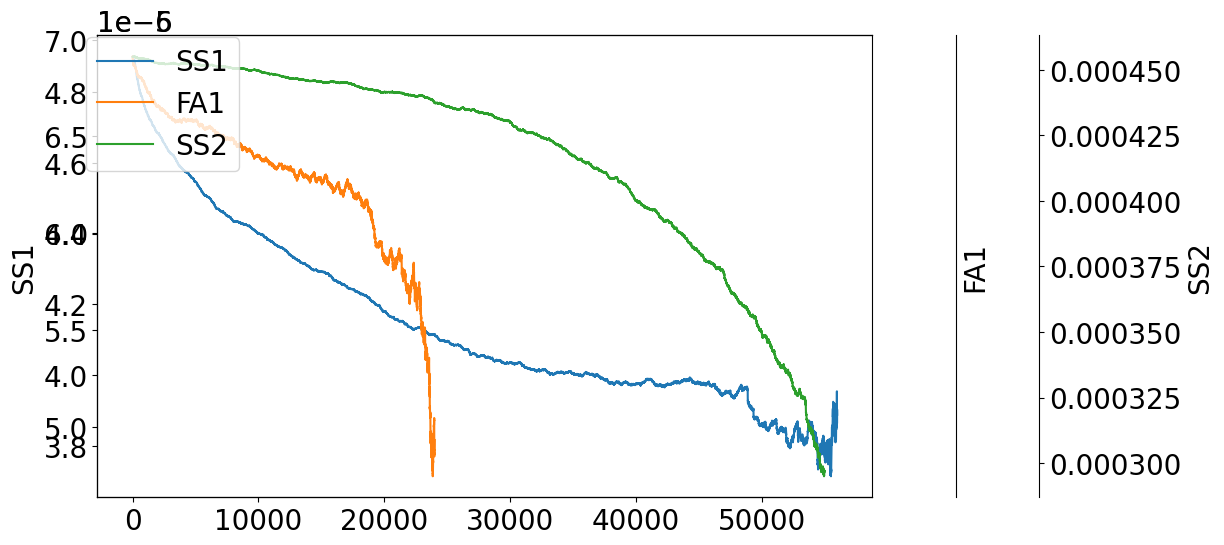

In [36]:
import matplotlib.pyplot as plt

# Assuming mse_sparcity_values_modes is your dictionary
modes = list(mse_sparcity_values_modes.keys())
n_modes = len(modes)
limits = [56000, 24000, 55000]
colors = ['tab:blue', 'tab:orange', 'tab:green']


fig, ax = plt.subplots(figsize=(10, 6))

# Initialize the rightmost axis
ax_right = ax

for i, mode in enumerate(modes):
    # Plot on the appropriate axis
    if i == 0:
        # Plot on the original axis for the first mode
        ax.plot(mse_sparcity_values_modes[mode][1:limits[i]], label=mode, color=colors[i])
    else:
        # Create a new axis for other modes
        ax_right = ax_right.twinx()
        ax_right.plot(mse_sparcity_values_modes[mode][1:limits[i]], label=mode, color=colors[i])
        # Offset each successive axis to the right
        ax_right.spines['right'].set_position(('outward', 60 * i))

    # Set the label for each y-axis
    ax_right.set_ylabel(mode)



# Set a general legend
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

plt.show()
